# Using physics informed neural networks (PINNs) to solve solid mechanics

Motivated by the Github Repo Jungang(Gordon) Chen on Usingg PINN to a continuum mechanincs problrm: Linear elasticity.  
[PINN_Solver_SolidMechanics_stack.ipynb](https://github.com/jungangc/PINN-for-solid-mechanics/blob/main/PINN_Solver_SolidMechanics_stack.ipynb)

# Required Libraries

In [ ]:
import tensorflow as tf
import numpy as np
from pyDOE2 import lhs  # a package used for Latin Hypercube Sampling (LHS) — a way of picking points that evenly spread out over a region, 
#good for sampling training points. LHS is like scattering seeds evenly in a garden so every patch gets a seed — it avoids clumping points together.

# Precision Setting
for more accurate computations.

In [17]:
# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE) # to confer  double precision for more accurate computations, backend Dtype is set to float64.

# Setting-up Boundaries and Material-specific constants

In [ ]:
# constants & model parameters
pi = tf.constant(np.pi, dtype=DTYPE)
E = tf.constant(4e11/3, dtype=DTYPE)                # Young's modulus. roughly 133 GPa, a realistic value for engineering materials.
v = tf.constant(1/3, dtype=DTYPE)                   # Poisson's ratio. ν = 1/3 is typical for metals (e,g., steel is around 0.3).
E = E/1e11                                          # Normalize Young's modulus to 1e11 for better numerical stability
                                                    # E is set to 4e11/3, which is a common value for materials like concrete or steel, and then normalized by dividing by 1e11.

# Lamé parameters 
lmda = tf.constant(E*v/(1-2*v)/(1+v), dtype=DTYPE)  #  linear elasticity theory, specifically Hooke’s Law for isotropic materials in 2D/3D:λ helps model volumetric expansion or compressio
mu = tf.constant(E/(2*(1+v)), dtype=DTYPE)          # shear modulus,describes  deformations under shear stress.y, the stress-strain relations use λ and μ to connect displacements (u) to stresses (σ).

# viscosity = .01/pi
Q = tf.constant(4.0, dtype=DTYPE)                   # a known distributed force (body force), controls the strength of the force applied to the system.

# Dirichlet boundary Conditions. Floating-point numbers are used to define the boundaries of the domain. xmin, xmax, ymin, ymax define the rectangular region where the PDE is solved.
xmin = 0.
xmax = 1.
ymin = 0.
ymax = 1.

# Define Exact Force and Displacements
To evaluate PINN's performance and accuracy.

1. **Exact Displacement**: 'Cos(2πx)sin(πy)', exact displacement in the x-direction  for a given point (x, y) in the domain. Then a normalized transformed coordinate alternative is tried. same for the displacement in the y direction 'Sin(πx)Q/4y^4'  
2. **Exact Force**: the exact force in the x-direction for a given point (x, y) in the domain. Derived by applying the Navier equations (idea: Momentum conservation) describing equilibrium of a deformable body.

3. **The Navier equations** for the displacement field u are: ∇⋅(σ) + ρb = 0 . where: σ is the Cauchy stress tensor, ρ is the mass density, and b is the body force vector.   
In linear elasticity, the Cauchy stress tensor is related to the displacement field through the Hooke's law, σ = λ(∇⋅u)I + 2μE. Where,  
λ and μ are Lamé parameters (material properties)  
I is the identity tensor  
E is the infinitesimal strain tensor, which is the symmetric part of the gradient of the displacement field: E = 1/2 (∇u + (∇u)ᵀ). 
  
4. Substituting Hooke's law into the Navier equation and assuming no body forces, we obtain:  (λ + 2μ)∇(∇⋅u) - μ∇×(∇×u) = 0. This equation represents a vector differential equation for the displacement field. It can be further simplified using vector identities, resulting in: (λ + 2μ)∇(∇⋅u) - μ∇×(∇×u) = 0   or   ∇⋅(σ) + ρb = 0



In [24]:
def u_x_ext(x, y):
    utemp = tf.cos(2*pi*x) * tf.sin(pi*(y))                                         
    # utemp = tf.cos(2*pi*(x-xmin)/(xmax-xmin)) * tf.sin(pi*(y-ymin)/(ymax-ymin))    
    return utemp
def u_y_ext(x, y):
    utemp = tf.sin(pi*x) * Q/4*tf.pow(y,4)                                           
    # utemp = tf.sin(pi*(x-xmin)/(xmax-xmin)) * Q/4*tf.pow((y-ymin)/(ymax-ymin),4)
    return utemp
def f_x_ext(x,y):
    gtemp = 1.0*(-4*tf.pow(pi,2)*tf.cos(2*pi*x)*tf.sin(pi*y)+pi*tf.cos(pi*x)*Q*tf.pow(y,3))+\
    0.5*(-9*tf.pow(pi,2)*tf.cos(2*pi*x)*tf.sin(pi*y)+pi*tf.cos(pi*x)*Q*tf.pow(y,3))           
    # gtemp = 1.0*(-4*tf.pow(pi,2)*tf.cos(2*pi*(x-xmin)/(xmax-xmin))*tf.sin(pi*(y-ymin)/(ymax-ymin))+pi*tf.cos(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),3))+\
    # 0.5*(-9*tf.pow(pi,2)*tf.cos(2*pi*(x-xmin)/(xmax-xmin))*tf.sin(pi*(y-ymin)/(ymax-ymin))+pi*tf.cos(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),3))
    return gtemp
def f_y_ext(x,y):
    gtemp = lmda*(3*tf.sin(pi*x)*Q*tf.pow(y,2)-2*tf.pow(pi,2)*tf.sin(2*pi*x)*tf.cos(pi*y))+\
            mu*(6*tf.sin(pi*x)*Q*tf.pow(y,2)-2*tf.pow(pi,2)*tf.sin(2*pi*x)*tf.cos(pi*y)-tf.pow(pi,2)*tf.sin(pi*x)*Q*tf.pow(y,4)/4)
    # gtemp = lmda*(3*tf.sin(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),2)-2*tf.pow(pi,2)*tf.sin(2*pi*(x-xmin)/(xmax-xmin))*tf.cos(pi*(y-ymin)/(ymax-ymin)))+\
    #     mu*(6*tf.sin(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),2)-2*tf.pow(pi,2)*tf.sin(2*pi*(x-xmin)/(xmax-xmin))*tf.cos(pi*(y-ymin)/(ymax-ymin))-tf.pow(pi,2)*tf.sin(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),4)/4)
    return gtemp

# Neumann Boundary condition
In linear elasticity, the Neumann boundary condition prescribes the traction force (stress vector) on the surface of an object. This means you specify the stress vector acting on the boundary, rather than the displacement itself, which is known as a Dirichlet condition. The Neumann condition is also referred to as a "natural" boundary condition because it can be directly incorporated into the variational formulation of the problem

In [5]:
# Define boundary conditions at top 
def fun_b_yy(x, y):
    return (lmda+2*mu)*Q*tf.sin(pi*x)
    # return (lmda+2*mu)*Q*tf.sin(pi*(x-xmin)/(xmax-xmin))

### 2. Generate a set of collocation points

In [6]:
# Set number of data points
# N_0 = 50
N_bound = 50
N_r = 1000

# Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

###########################################################################
# Boundary points
x_up = lhs(1,samples=N_bound,random_state=123)
x_up = xmin + (xmax-xmin)*x_up
y_up = np.empty(len(x_up))[:,None]
y_up.fill(ymax)
b_up = np.empty([len(x_up),2])
print(b_up.shape)
b_up[:,0,None] = u_x_ext(x_up, y_up)
b_up[:,1,None] = u_y_ext(x_up, y_up)
x_up_train = np.hstack((x_up, y_up))
# ux_up_train = b_up[:,0, None] 
# uy_up_train = b_up[:,1, None] 
ux_up_train = np.zeros([len(x_up),1])
Syy_up_train = fun_b_yy(x_up, y_up)

x_lo = lhs(1,samples=N_bound,random_state=123)
x_lo = xmin + (xmax-xmin)*x_lo
y_lo = np.empty(len(x_lo))[:,None]
y_lo.fill(ymin)
b_lo = np.empty([len(x_lo),2])
b_lo[:,0, None] = u_x_ext(x_lo, y_lo)
b_lo[:,1, None] = u_y_ext(x_lo, y_lo)
x_lo_train = np.hstack((x_lo, y_lo))
# ux_lo_train = b_lo[:,0, None] 
# uy_lo_train = b_lo[:,1, None] 
ux_lo_train = np.zeros([len(x_lo),1])
uy_lo_train = np.zeros([len(x_lo),1])

y_ri = lhs(1,samples=N_bound,random_state=123)
y_ri = ymin + (ymax-ymin)*y_ri
x_ri = np.empty(len(y_ri))[:,None]
x_ri.fill(xmax)
b_ri = np.empty([len(x_ri),2])
b_ri[:,0, None] = u_x_ext(x_ri, y_ri)
b_ri[:,1, None] = u_y_ext(x_ri, y_ri)
x_ri_train = np.hstack((x_ri, y_ri)) 
# ux_ri_train = b_ri[:,0, None]
# uy_ri_train = b_ri[:,1, None]
uy_ri_train = np.zeros([len(x_ri),1])
Sxx_ri_train = np.zeros([len(x_ri),1])

y_le = lhs(1,samples=N_bound,random_state=123)
y_le = ymin + (ymax-ymin)*y_le
x_le = np.empty(len(y_le))[:,None]
x_le.fill(xmin)
b_le = np.empty([len(x_le),2])
b_le[:,0, None] = u_x_ext(x_le, y_le)
b_le[:,1, None] = u_y_ext(x_le, y_le)
x_le_train = np.hstack((x_le, y_le))
# ux_le_train = b_le[:,0, None]
# uy_le_train = b_le[:,1, None]
uy_le_train = np.zeros([len(x_le),1])
Sxx_le_train = np.zeros([len(x_le),1])

X_b_train = np.concatenate((x_up_train, x_lo_train, x_ri_train, x_le_train))
X_train_list = [x_up_train, x_lo_train, x_ri_train, x_le_train]
# ux_b_train = np.concatenate((ux_up_train, ux_lo_train, ux_ri_train, ux_le_train))
# uy_b_train = np.concatenate((uy_up_train, uy_lo_train, uy_ri_train, uy_le_train))
ux_b_train = np.concatenate((ux_up_train, ux_lo_train))
uy_b_train = np.concatenate((uy_lo_train, uy_ri_train, uy_le_train))
Sxx_b_train = np.concatenate((Sxx_ri_train, Sxx_le_train))
Syy_b_train = Syy_up_train

#########################################################################
# collocation points for PINNs
grid_pt = lhs(2,N_r)
grid_pt[:,0] = xmin + (xmax-xmin)*grid_pt[:,0]
grid_pt[:,1] = ymin + (ymax-ymin)*grid_pt[:,1]
xf = grid_pt[:,0]
yf = grid_pt[:,1]
# ff_x = np.asarray([ f_x_ext(xf[j],yf[j]) for j in range(len(yf))])
# ff_y = np.asarray([ f_y_ext(xf[j],yf[j]) for j in range(len(yf))])
# f_x_train = ff_x
# f_y_train = ff_y
X_col_train = np.hstack((xf[:,None],yf[:,None]))

(50, 2)


Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

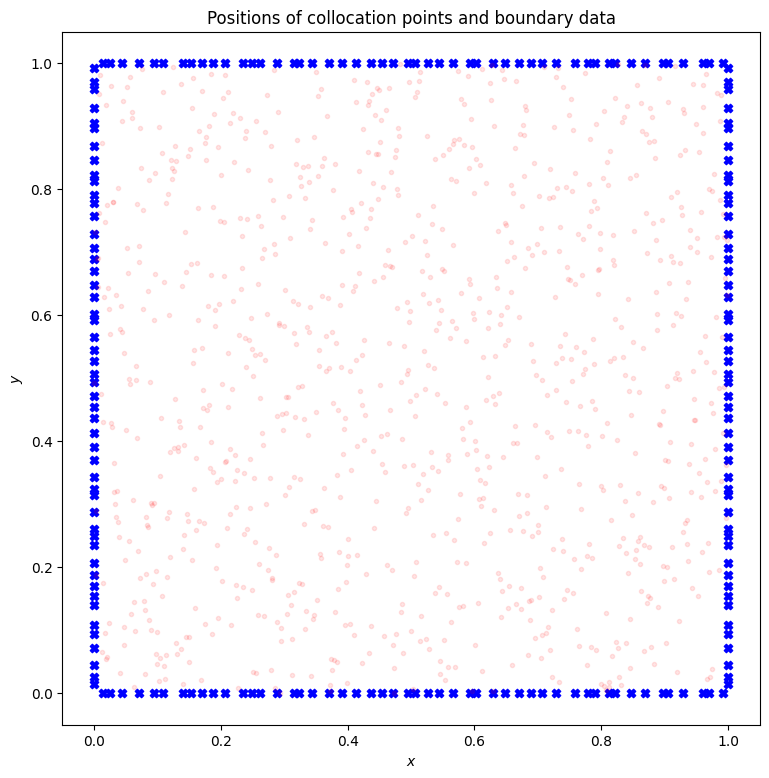

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,9))
plt.scatter(X_b_train[:,0], X_b_train[:,1], c='blue', marker='X')
plt.scatter(X_col_train[:,0], X_col_train[:,1], c='r', marker='.', alpha=0.1)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

### 3. Set up network architecture


In [8]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (two spatial dimensions)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dropout(0.2))
    # Output is two-dimensional
    model.add(tf.keras.layers.Dense(2))
    
    return model

### 4. Define routines to determine loss and gradient


In [9]:
# Define residual of the PDE in x direction
def fun_r_x(x, y, dsxxdx, dsxydy):
    # return (lmda+2*mu)*ux_xx+lmda*uy_xy+mu*(ux_yy+uy_xy)-f_x_ext(x,y)
    return dsxxdx+dsxydy-f_x_ext(x,y)
# Define residual of the PDE in y direction
def fun_r_y(x, y, dsxydx, dsyydy):
    return dsxydx+dsyydy-f_y_ext(x,y)
    # return mu*(ux_xy+uy_xx)+(lmda+2*mu)*uy_yy+lmda*ux_xy-f_y_ext(x,y)

def get_r(model, X_col_train):
    # Split x and y to compute partial derivatives
    x = tf.constant(X_col_train[:, 0:1])
    y = tf.constant(X_col_train[:, 1:2])
    # A tf.GradientTape is used to compute derivatives in TensorFlow

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        tape2.watch(y)
        # Determine residual 
        Ux, Uy, Sxx, Syy, Sxy = model(tf.stack([x[:,0], y[:,0]], axis=1))
        sxx = Sxx
        syy = Syy
        sxy = Sxy
        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
    dsxxdx, dsxxdy = tape2.gradient(sxx, (x,y))
    dsyydx, dsyydy = tape2.gradient(syy, (x,y))
    dsxydx, dsxydy = tape2.gradient(sxy, (x,y))

    del tape2
    return fun_r_x(x, y, dsxxdx, dsxydy), fun_r_y(x, y, dsxydx, dsyydy)

In [10]:
# Define residual of the PDE in x direction
def fun_r_const_x(x, y, duxdx, duydy,Sxx):
    # return (lmda+2*mu)*ux_xx+lmda*uy_xy+mu*(ux_yy+uy_xy)-f_x_ext(x,y)
    return (lmda+2*mu)*duxdx+lmda*duydy-Sxx
# Define residual of the PDE in y direction
def fun_r_const_y(x, y, duxdx, duydy, Syy):
    return (lmda+2*mu)*duydy+lmda*duxdx-Syy
    # return mu*(ux_xy+uy_xx)+(lmda+2*mu)*uy_yy+lmda*ux_xy-f_y_ext(x,y)
# Define residual of the PDE in xy direction
def fun_r_const_xy(x, y, duxdy, duydx, Sxy):
    return 2*mu*0.5*(duxdy+duydx)-Sxy
    # return mu*(ux_xy+uy_xx)+(lmda+2*mu)*uy_yy+lmda*ux_xy-f_y_ext(x,y)

def get_r_const(model, X_col_train):
    # Split x and y to compute partial derivatives
    x = tf.constant(X_col_train[:, 0:1])
    y = tf.constant(X_col_train[:, 1:2])
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape2:
#             # Variables x and y are watched during tape
#             # to compute derivatives u_t and u_x
        tape2.watch(x)
        tape2.watch(y)
        # Determine residual 
        # U = model(tf.stack([x[:,0], y[:,0]], axis=1))
        # ux = U[:,0]
        # uy = U[:,1]
        Ux, Uy, Sxx, Syy, Sxy = model(tf.stack([x[:,0], y[:,0]], axis=1))
        ux = Ux
        uy = Uy
        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
    duxdx, duxdy = tape2.gradient(ux, (x,y))
    duydx, duydy = tape2.gradient(uy, (x,y))
    del tape2
    return fun_r_const_x(x, y, duxdx, duydy,Sxx), fun_r_const_y(x, y, duxdx, duydy, Syy), fun_r_const_xy(x, y, duxdy, duydx, Sxy)

In [11]:
# boundary condition with fixed displacement (Dirichlet boundary condition)
def fun_b_r_ux(ux_up, ux_lo, ux_b_train):
    # ux_b_temp = tf.stack([ux_up, ux_lo],axis=0)
    return   tf.concat([ux_up, ux_lo], 0)-ux_b_train

def fun_b_r_uy(uy_lo, uy_ri,uy_le, uy_b_train):
    # uy_b_temp = tf.stack([uy_lo, uy_ri, uy_le],axis=0)
    return  tf.concat([uy_lo, uy_ri, uy_le], 0)-uy_b_train

def get_b_r_u(model, X_train_list, ux_b_train, uy_b_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train = X_train_list[0], \
                    X_train_list[1], X_train_list[2], X_train_list[3]
    # Split t and x to compute partial derivatives
    x_up, y_up = x_up_train[:, 0:1], x_up_train[:,1:2]
    x_lo, y_lo = x_lo_train[:, 0:1], x_lo_train[:,1:2]
    x_ri, y_ri = x_ri_train[:, 0:1], x_ri_train[:,1:2]
    x_le, y_le = x_le_train[:, 0:1], x_le_train[:,1:2]
    # Determine residual 
    Ux_up, Uy_up, Sxx, Syy, Sxy  = model(tf.stack([x_up[:,0], y_up[:,0]], axis=1))
    ux_up, _ = Ux_up, Uy_up
    Ux_lo, Uy_lo, Sxx, Syy, Sxy  = model(tf.stack([x_lo[:,0], y_lo[:,0]], axis=1))
    ux_lo, uy_lo = Ux_lo, Uy_lo
    Ux_ri, Uy_ri, Sxx, Syy, Sxy  = model(tf.stack([x_ri[:,0], y_ri[:,0]], axis=1))
    _, uy_ri = Ux_ri, Uy_ri
    Ux_le, Uy_le, Sxx, Syy, Sxy  = model(tf.stack([x_le[:,0], y_le[:,0]], axis=1))
    _, uy_le = Ux_le, Uy_le
    
    return fun_b_r_ux(ux_up, ux_lo, ux_b_train), fun_b_r_uy(uy_lo, uy_ri,uy_le, uy_b_train)

In [12]:
# boundary condition with fixed stress (Neumann boundary condition)
def fun_b_r_Sxx(Sxx_ri, Sxx_le, Sxx_b_train):
    return tf.concat([Sxx_ri,Sxx_le], 0)-Sxx_b_train

def fun_b_r_Syy(Syy_up, Syy_b_train):
    return Syy_up-Syy_b_train

def get_b_r_S(model,X_train_list , Sxx_b_train, Syy_b_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train = X_train_list[0], \
                    X_train_list[1], X_train_list[2], X_train_list[3]
    # A tf.GradientTape is used to compute derivatives in TensorFlow

    ## up boundary
    x_up = tf.constant(x_up_train[:, 0:1])
    y_up = tf.constant(x_up_train[:, 1:2])

    Ux_up, Uy_up, Sxx_up, Syy_up, Sxy_up  = model(tf.stack([x_up[:,0], y_up[:,0]], axis=1))

    ## right boundary
    x_ri = tf.constant(x_ri_train[:, 0:1])
    y_ri = tf.constant(x_ri_train[:, 1:2])

    Ux_ri, Uy_ri, Sxx_ri, Syy_ri, Sxy_ri = model(tf.stack([x_ri[:,0], y_ri[:,0]], axis=1))

    ## left boundary    
    x_le = tf.constant(x_le_train[:, 0:1])
    y_le = tf.constant(x_le_train[:, 1:2])

    Ux_le, Uy_le, Sxx_le, Syy_le, Sxy_le = model(tf.stack([x_le[:,0], y_le[:,0]], axis=1))
    
    return fun_b_r_Sxx(Sxx_ri, Sxx_le, Sxx_b_train), fun_b_r_Syy(Syy_up, Syy_b_train)

In [13]:
def compute_loss(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train = X_train_list[0],\
                    X_train_list[1], X_train_list[2], X_train_list[3]
    # Compute phi^r use absolute error
    rx, ry = get_r(model, X_col_train)
    # phi_r = tf.reduce_mean(tf.square(rx)) + tf.reduce_mean(tf.square(ry))
    phi_r = tf.reduce_mean(tf.abs(rx)) + tf.reduce_mean(tf.abs(ry))

    rx_const, ry_const, rxy_const = get_r_const(model, X_col_train)
    # phi_r_const = tf.reduce_mean(tf.square(rx_const)) + tf.reduce_mean(tf.square(ry_const))+tf.reduce_mean(tf.square(rxy_const))
    phi_r_const = tf.reduce_mean(tf.abs(rx_const)) + tf.reduce_mean(tf.abs(ry_const))+tf.reduce_mean(tf.abs(rxy_const))

    # Compute phi^b
    r_ux, r_uy = get_b_r_u(model, X_train_list, ux_b_train, uy_b_train)
    # phi_r_u = tf.reduce_mean(tf.square(r_ux)) + tf.reduce_mean(tf.square(r_uy))
    phi_r_u = tf.reduce_mean(tf.abs(r_ux)) + tf.reduce_mean(tf.abs(r_uy))
    
    # Compute phi^b
    r_Sxx, r_Syy = get_b_r_S(model, X_train_list, Sxx_b_train, Syy_b_train)
    # phi_r_S = tf.reduce_mean(tf.square(r_Sxx)) + tf.reduce_mean(tf.square(r_Syy))
    phi_r_S = tf.reduce_mean(tf.abs(r_Sxx)) + tf.reduce_mean(tf.abs(r_Syy))
    
    loss = phi_r+ phi_r_const + phi_r_u + phi_r_S 

    return loss

In [14]:
def get_grad(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

### 5. Set up optimizer and train model

In [15]:
# # Initialize model aka u_\theta
# model = init_model()
num_hidden_layers, num_neurons_per_layer = 8, 20
input_layer = tf.keras.Input(2)

# Introduce a scaling layer to map input to [lb, ub]
scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
x = scaling_layer(input_layer)

# Append hidden layers
for _ in range(num_hidden_layers):
    x = tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'),\
        kernel_initializer='glorot_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
# Output is two-dimensional
output_Ux = tf.keras.layers.Dense(1)(x)
output_Uy = tf.keras.layers.Dense(1)(x)
output_Sxx = tf.keras.layers.Dense(1)(x)
output_Syy = tf.keras.layers.Dense(1)(x)
output_Sxy = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inputs=input_layer, outputs=[output_Ux, output_Uy, output_Sxx, output_Syy, output_Sxy])

# model.summary()
# print(model.trainable_variables)
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

ValueError: Cannot convert '2' to a shape.

Train the model for $N=5000$ epochs (takes approximately 3 minutes).
Here, we set up a function `train_step()` which performs one training step.

*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_col_train,X_train_list,ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
  loss = train_step()
   
  if i==0:
    loss0 = loss
    # Append current loss to hist
  hist.append(loss.numpy()/loss0.numpy())
    
  # Output current loss after 50 iterates
  if i%50 == 0:
      print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.24856952e+01
It 00050: loss = 4.10542948e+01
It 00100: loss = 1.29747578e+01
It 00150: loss = 8.39511379e+00
It 00200: loss = 6.58371147e+00
It 00250: loss = 5.37012407e+00
It 00300: loss = 5.82760152e+00
It 00350: loss = 6.71317161e+00
It 00400: loss = 4.49193646e+00
It 00450: loss = 6.76550681e+00
It 00500: loss = 4.18064347e+00
It 00550: loss = 4.05269804e+00
It 00600: loss = 5.65556569e+00
It 00650: loss = 3.65304279e+00
It 00700: loss = 4.25482389e+00
It 00750: loss = 3.78931454e+00
It 00800: loss = 4.26452820e+00
It 00850: loss = 3.91602019e+00
It 00900: loss = 3.77409996e+00
It 00950: loss = 4.33919697e+00
It 01000: loss = 3.35377441e+00
It 01050: loss = 1.22561004e+00
It 01100: loss = 1.16199627e+00
It 01150: loss = 1.11951776e+00
It 01200: loss = 1.08528118e+00
It 01250: loss = 1.05302850e+00
It 01300: loss = 1.02109061e+00
It 01350: loss = 9.91973095e-01
It 01400: loss = 9.65664023e-01
It 01450: loss = 9.42642276e-01
It 01500: loss = 9.34457728e-01
It 01550

### Plot solution

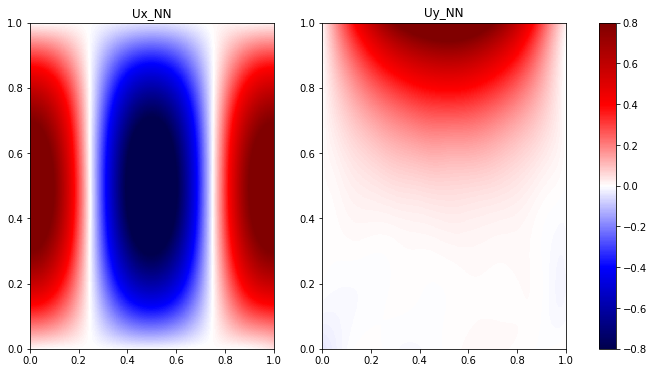

In [ ]:
# Set up meshgrid
N = 600
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T

# Determine predictions of u(t, x)
Ux_pred, Uy_pred, Sxx_pred, Syy_pred, Sxy_pred = model(tf.cast(Xgrid,DTYPE))
ux_pred = Ux_pred
uy_pred = Uy_pred 

# Reshape upred
Ux = ux_pred.numpy().reshape(N+1,N+1)
Uy = uy_pred.numpy().reshape(N+1,N+1)

U_total = [Ux, Uy]
U_total_name = ['Ux_NN', 'Uy_NN']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, U_total[i], cmap='seismic', vmin=-0.8, vmax=0.8)
    ax.set_title(U_total_name[i])

fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

### Plot error map

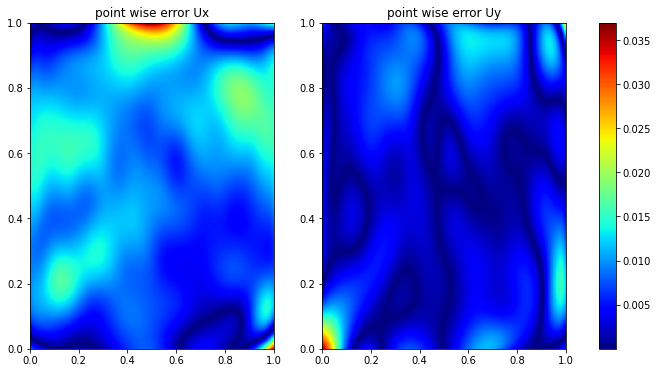

In [ ]:
# calculate exact solutions
ux_ext = u_x_ext(X.flatten(),Y.flatten())
uy_ext = u_y_ext(X.flatten(),Y.flatten())

# Reshape upred
Ux_ext = ux_ext.numpy().reshape(N+1,N+1)
Uy_ext = uy_ext.numpy().reshape(N+1,N+1)

# fig.tight_layout()
# plt.show()
error_total = [abs(Ux-Ux_ext), abs(Uy-Uy_ext)]
error_total_name = ['point wise error Ux', 'point wise error Uy']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, error_total[i], cmap='jet')
    ax.set_title(error_total_name[i])

fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

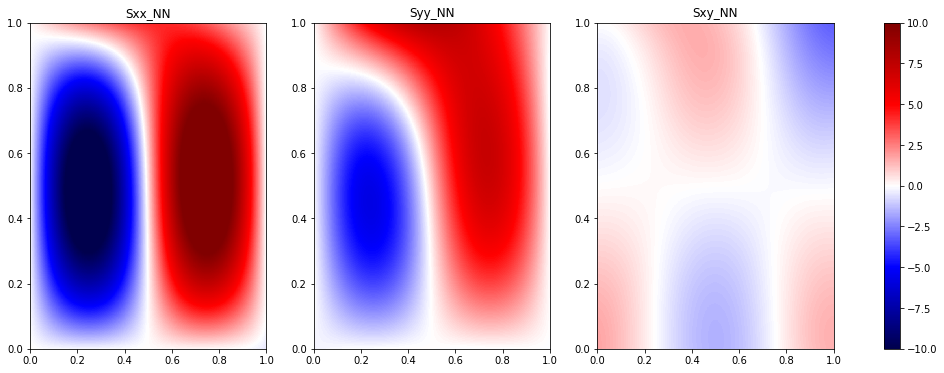

In [ ]:

# Determine predictions of u(t, x)
Ux_pred, Uy_pred, Sxx_pred, Syy_pred, Sxy_pred = model(tf.cast(Xgrid,DTYPE))
sxx_pred = Sxx_pred
syy_pred = Syy_pred
sxy_pred = Sxy_pred

# Reshape upred
Sxx = sxx_pred.numpy().reshape(N+1,N+1)
Syy = syy_pred.numpy().reshape(N+1,N+1)
Sxy = sxy_pred.numpy().reshape(N+1,N+1)

S_total = [Sxx, Syy, Sxy]
S_total_name = ['Sxx_NN', 'Syy_NN', 'Sxy_NN']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, S_total[i], cmap='seismic', vmin=-10, vmax=10)
    ax.set_title(S_total_name[i])

fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

### Plot the evolution of loss

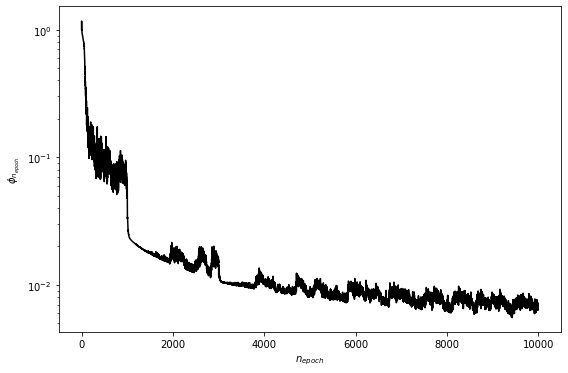

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

In [ ]:
import pickle
filename = 'solidmechanics_model_stack.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# model.summary()

In [ ]:
model.compiled_metrics == None

True

## Class implementation of PINNs

In this section, we implement PINNs as a class which can be used for further testing. Here, we derive the class `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`.